# pairAGraph training example

The goal of this notebook is to demonstrate how to do the preprocessing from MNTs, train a model, and then evaluate the accuracy and get the $m_{hh}$ distribution in the SR.

This notebook mostly is calling functions inside of the `preprocess.py` and `trainNet.py` modules.


In [1]:
import pandas as pd
import numpy as np
import torch
import json

import matplotlib.pyplot as plt

from preprocess import getNumPairs, scale, transformData, prepareData, processDf
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy
from GNNPlots import trainingMetrics

from preprocess import getHCs, applyCuts, getHelicityAngles
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path.append('../code')
from analysis import normalizeWeight

# The lines below let you edit codes in modules and update the function definitions
# in your notebook automatically without having to load them in again.
%load_ext autoreload
%autoreload 2

## Step 1: MNT preprocessing

This step get the MNT, takes the first five (leading in $p_T$) jets in the event and stores them in flat numpy arrays.
It additionally the $b$-quark -> jet matching and defines the "correct pairs" to be used as truth labels for the training.
 
Justification for the choice of choosing the leading 5 $p_T$ jets without an additional sort is shown in the plot below, if you keep the 40 GeV $p_T$ cut, you almost always keep all the signal jets if you take the first five.
 
<img src="figures/EDA/bquarkMatch_nJetsMax.png" width=400>

(For further details, see the `Streamlining-Preprocessing` nb.)

In [2]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

reload = False

After calling this function, we still need to apply the 4-jet and 3b cuts. The `year` option tells you which set of triggers to apply, but a cut isn't made on them at this stage since I didn't want the training to have to learn about the different turn-on curves for the different years.

In [3]:
if reload:

    # mc16a
    mc16a_filename = "../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root"
    
    df1 = processDf(mc16a_filename,nJetsMax=nSelectedJets,pT_min=40)
    df1[(df1.njets>=4) & (df1.ntag>=3)].to_hdf('../data/SMNR_mc16a_PFlow-MAR2020-5jets/df_3b.h5',key='df')
    
    # mc16d
    mc16d_filename = '../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16d-2017.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736216._00000{}.MiniNTuple.root'

    df2 = processDf(mc16d_filename.format(1), nJetsMax=nSelectedJets, pT_min=40, year=2017)
    df3 = processDf(mc16d_filename.format(2), nJetsMax=nSelectedJets, pT_min=40, year=2017)
    
    dfd = pd.concat([df2[(df2.njets>=4) & (df2.ntag>=3)],df3[(df3.njets>=4) & (df3.ntag>=3)]])
    dfd.to_hdf('../data/SMNR_mc16d_PFlow-MAR2020-5jets/df_3b.h5',key='df')
    
    # mc16e
    mc16e_filename = '../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16e-2018.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736225._00000{}.MiniNTuple.root'
    df4 = processDf(mc16e_filename.format(1),nJetsMax=nJetsMax,pT_min=40, year=2018)
    df5 = processDf(mc16e_filename.format(2),nJetsMax=nJetsMax,pT_min=40, year=2018)
    
    dfe = pd.concat([df4[(df4.njets>=4) & (df4.ntag>=3)],df5[(df5.njets>=4) & (df5.ntag>=3)]])
    dfe.to_hdf('../data/SMNR_mc16e_PFlow-MAR2020-5jets/df_3b.h5',key='df')

In [3]:
if reload:
    # And this function concatenates the mc campaigns and does the ml preprocessing
    prepareData(nSelectedJets,prodTag=prodTag)

## Step 2: Training

This step is better run on a gpu, so I'd recommend not running from a notebook, but rather in a terminal.

The training script is `trainNet.py`, and the default options are best the ones from a hyperparameter scan I performed before on mc16a.

For the training enviornment - you can use the following sinularity image.

`singularity exec --nv docker://gitlab-registry.cern.ch/hartman/ml-gpu/ml-gpu:latest python trainNet.py`

This will:
- Retrieve the dfs for the individual campaigns that we saved above, and apply the ML prescaling 
- Define the pairAGraph model
- Continue training until the validation loss hasn't improved in the last 5 epochs.
- Make and draw the corresponding loss and accuracy evolution over training curves.

You can see the other configurable options by running:

`python trainNet.py --help`



**Set up the model skeleton**

In [4]:
GNNParams= {'physicsSample': 'SMNR',
            'mc': 'mc16ade',
            'prodTag': 'MAR2020',
            'nSelectedJets': 5,
            'nLayers': 1,
            'embed_dim': 20, 
            'ff_dim': 20,
            'nHeads': 4,
            'dpt': 0.3,
            'lr': 0.01,
            'epoch': 17}

nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']

# Load in the model
jetVars = ['pt','eta','phi','E','Db']
model = pairAGraph(inpt_dim=len(jetVars),embed_dim=embed_dim,ff_dim=ff_dim,
                   nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)

**Load in the model weights**

In [5]:
xformerDir = f'xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_jetCompatibility_lr{lr}_batch2048'
modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/{xformerDir}"
model.load_state_dict(torch.load(f'{modelDir}/model_epoch17.pt',map_location='cpu'))
model.eval()

pairAGraph(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (encoderLayer1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=20, out_features=20, bias=True)
    )
    (linear1): Linear(in_features=20, out_features=20, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (finalAttnLayer): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

Below are the visualizations for the training metrics created during the training

In [7]:
with open(f'{modelDir}/loss_acc.json', 'r') as loss_acc:
    metrics = json.load(loss_acc)

In [8]:
np.argmax(metrics['val_acc'])

17

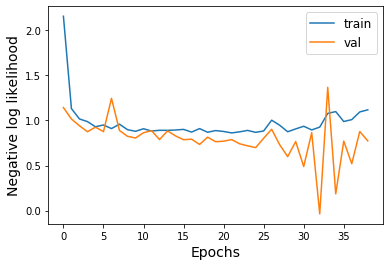

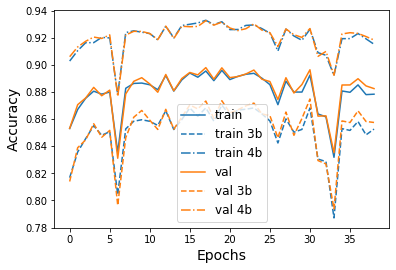

In [9]:
trainingMetrics(metrics)

## Step 3: Evaluate the performance

I'm using the *odd* events fro the training and evaluation sets.

In [6]:
mc = 'mc16a'

In [7]:
subDir = f'{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets'

In [8]:
Ls = {
        15: 3.2,
        'a': 24.5556, # for now - just use the 2016 luminosity to normalize mc16a
        'd': 43.65,
        'e': 58.45
    }

In [9]:
df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
df = df[df.index % 2 == 0]

# Since I'm only using half the stats for the test set, need to multiply L by 2.
L = Ls[mc[-1]]
key = f'{physicsSample}_{mc}_PFlow-{prodTag}'
print(key)
normalizeWeight(df,key,lumi=L*2)

SMNR_mc16a_PFlow-MAR2020
/u/ki/nhartman/gpfs/public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root
sum_weights_initial 26458.62742272562
Reading entry for DSID 450000:
  xsec 27.47
  k_factor 1.13
  gen_filter_eff 0.3392
  sample_weight 0.019543672735207792


**Apply the rest of the analysis cuts**

In [12]:
applyCuts(df,model,nSelectedJets)

max(njets) 5
Getting jet pts
Getting jet etas
Getting jet phis
Getting jet Es
Calculating Xwt
Calculating Xhh


In [13]:
for c in df.columns:
    print(c)

eventNumber
nresolvedJets
resolved_nBTags
mcEventWeight
weight_pileup
rand_run_nr
j0_pt
j0_eta
j0_phi
j0_E
j0_Db
j0_sf
j1_pt
j1_eta
j1_phi
j1_E
j1_Db
j1_sf
j2_pt
j2_eta
j2_phi
j2_E
j2_Db
j2_sf
j3_pt
j3_eta
j3_phi
j3_E
j3_Db
j3_sf
j4_pt
j4_eta
j4_phi
j4_E
j4_Db
j4_sf
njets
HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25
HLT_j100_2j55_bmv2c2060_split
HLT_j225_bmv2c2060_split
trigger
mc_sf
ntag
h0_pt
h0_eta
h0_phi
h0_barcode
h1_pt
h1_eta
h1_phi
h1_barcode
b0_pt
b0_eta
b0_phi
b0_parent_barcode
b1_pt
b1_eta
b1_phi
b1_parent_barcode
b2_pt
b2_eta
b2_phi
b2_parent_barcode
b3_pt
b3_eta
b3_phi
b3_parent_barcode
truth_mhh
truth_pthh
b0_jidx
b0_drMatch
b1_jidx
b1_drMatch
b2_jidx
b2_drMatch
b3_jidx
b3_drMatch
j0_bidx
j1_bidx
j2_bidx
j3_bidx
j4_bidx
j0_drMatch
j1_drMatch
j2_drMatch
j3_drMatch
j4_drMatch
correctPair
sameParent
unique
dRmatch
goodJets
ml_j0_pt
ml_j1_pt
ml_j2_pt
ml_j3_pt
ml_j4_pt
ml_j0_eta
ml_j1_eta
ml_j2_eta
ml_j3_eta
ml_j4_eta
ml_j0_phi
ml_j1_phi
ml_j2_phi
ml_j3_phi
ml_j4_phi
ml_j0_E
ml_

**Accuracy on the test set - and broken down by the jet categories**

In [15]:
for nj in [4,5]:
    print(f'{nj} jets')
    for nb,m in zip([4,3],[(df.ntag>=4),(df.ntag==3)]):
        mask = (df.njets == nj) & m
        acc = np.sum(df.loc[(df.predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
        print(f'  {nb}b acc: {acc*100:.2f} %')

4 jets
  4b acc: 77.82 %
  3b acc: 29.56 %
5 jets
  4b acc: 75.52 %
  3b acc: 34.01 %


Comparing to the events where a correct pair exists:

In [16]:
for nj in [4,5]:
    print(f'{nj} jets')
    for nb,m in zip([4,3],[(df.ntag>=4),(df.ntag==3)]):
        mask = (df.njets == nj) & m & (df.goodJets)
        acc = np.sum(df.loc[(df.predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
        print(f'  {nb}b acc: {acc*100:.2f} %')

4 jets
  4b acc: 93.52 %
  3b acc: 91.79 %
5 jets
  4b acc: 90.04 %
  3b acc: 79.36 %


In [36]:
mask = (df.ntag>=4) & (df.goodJets)
acc = np.sum(df.loc[(df.predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
acc

0.9164326476117711

In [37]:
mask = (df.ntag>=4) & (df.goodJets)
acc = np.sum(df.loc[(df.predPair == df.correctPair) & mask,'mcEventWeight']) /np.sum(df.loc[mask,'mcEventWeight'])
acc

0.91613364

In [17]:
# for c in df.columns:
#     print(c)

Ok, so from previous studies, it seems like for algorithms that use ML in the pairing, we don't need the MDR or mass dependent $p_T$ cuts, so the $m_{hh}$ plot below just shows
- trigger
- b-tagging 
- $\Delta \eta_{hh}$
- $X_{wt}$
- SR definition

In [18]:
if not os.path.exists(f'figures/{subDir}'):
    os.mkdir(f'figures/{subDir}')

if not os.path.exists(f'figures/{subDir}/{xformerDir}'):
    os.mkdir(f'figures/{subDir}/{xformerDir}')

In [19]:
fourbText = "$\mathbf{ATLAS}$ Simulation Internal\n"
fourbText += f"SM NR {mc} MAR 2020 MNT\n"
fourbText += "2016 triggers, DL1r at 77% WP, pairAGraph"

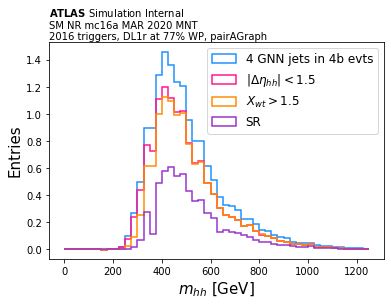

In [20]:
plt.figure()

mask = (df.ntag>=4)&(df.trigger)
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='4 GNN jets in 4b evts',
         weights=df.loc[mask,'mc_sf'],color='dodgerblue',linewidth=1.5)

mask = mask & df.cut_deta_hh
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='$|\Delta \eta_{hh}| < 1.5$',
         weights=df.loc[mask,'mc_sf'],color='deeppink',linewidth=1.5)

mask = mask & df.cut_Xwt
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='$X_{wt} > 1.5$',
         weights=df.loc[mask,'mc_sf'],color='darkorange',linewidth=1.5)

mask = mask & (df.kinematic_region == 0)
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='SR',
         weights=df.loc[mask,'mc_sf'],color='darkorchid',linewidth=1.5)

plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,fourbText,ha='left',va='bottom',transform=ax.transAxes)
plt.savefig(f'figures/{subDir}/{xformerDir}/m_hh_4b_analysisCuts.pdf')
plt.show()

In [21]:
np.sum(df.loc[mask,'mc_sf'])

6.098742635355645

In [22]:
6.03 * .93 * 2 / (.903+.874)

6.311648846370288

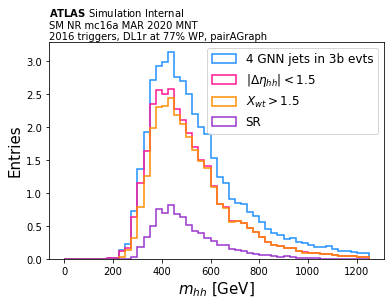

In [23]:
plt.figure()

mask = (df.ntag==3)&(df.trigger)
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='4 GNN jets in 3b evts',
         weights=df.loc[mask,'mc_sf'],color='dodgerblue',linewidth=1.5)

mask = mask & df.cut_deta_hh
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='$|\Delta \eta_{hh}| < 1.5$',
         weights=df.loc[mask,'mc_sf'],color='deeppink',linewidth=1.5)

mask = mask & df.cut_Xwt
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='$X_{wt} > 1.5$',
         weights=df.loc[mask,'mc_sf'],color='darkorange',linewidth=1.5)

mask = mask & (df.kinematic_region == 0)
plt.hist(df.loc[mask,'m_hh'],50,(0,1250),histtype='step',label='SR',
         weights=df.loc[mask,'mc_sf'],color='darkorchid',linewidth=1.5)

plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,fourbText,ha='left',va='bottom',transform=ax.transAxes)
plt.savefig(f'figures/{subDir}/{xformerDir}/m_hh_3b_analysisCuts.pdf')
plt.show()

In [24]:
np.sum(df.loc[mask,'mc_sf'])

8.11031387296815

**Sanity check:** Comparing inputs on the training and test dataset, b/c I am confused why the accuracies are lower on the test set when it doesn't seem like the model was overfitting based on the loss / accuracy metrics.

In [25]:
df_tr = pd.read_hdf('../data/SMNR_mc16ade_PFlow-MAR2020-5jets/df_3b_scaledInputs_train.h5',key='df')

In [26]:
jetVars = ['pt','eta','phi','E','Db']

X0 = np.dstack([df_tr.loc[df_tr.correctPair!=-1,['ml_j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in jetVars])
X1 = np.dstack([df.loc[df.correctPair!=-1,['ml_j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in jetVars])
    

In [27]:
m0 = ~ np.all(X0==0, axis=-1)
m1 = ~ np.all(X1==0, axis=-1)

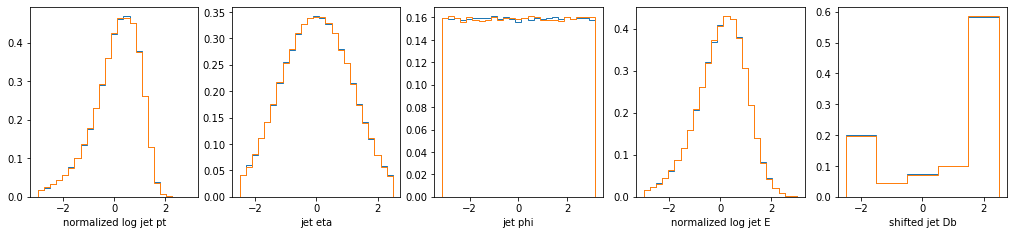

In [28]:
fig,axes = plt.subplots(1,len(jetVars),figsize=(3.5*len(jetVars),3.5))

myRanges = [(0,500),(-2.5,2.5),(-np.pi,np.pi),(0,600),[0.5,5.5]]
myBins = [25]*4 + [5]

for vi,(v,ax,r,n) in enumerate(zip(jetVars,axes,[(-3,3)]+myRanges[1:3]+[(-3,3),(-2.5,2.5)],myBins)): 
    ax.hist(X0[:,:,vi][m0],n,range=r,histtype='step', density=True)#weights=ws[mask])
    ax.hist(X1[:,:,vi][m1],n,range=r,histtype='step', density=True)
    
    if (v == 'pt') or (v == 'E'): 
        xlabel='normalized log '
    elif v == 'Db':
        xlabel = 'shifted '
    else:
        xlabel = ''
    xlabel += f"jet {v}"
    ax.set_xlabel(xlabel)   

inptStr = "_".join(jetVars)
plt.subplots_adjust()


Ok - this was just a sanity check that my preprocessing b/w the train and test sets was consistent.

In [29]:
metrics.keys()

dict_keys(['train_loss', 'train_acc', 'train_acc_3b', 'train_acc_4b', 'train_acc_4j', 'train_acc_5j', 'val_loss', 'val_acc', 'val_acc_3b', 'val_acc_4b', 'val_acc_4j', 'val_acc_5j'])

In [30]:
metrics['val_acc_4j'][17]

0.9442061185836792

In [31]:
metrics['val_acc_4b'][17]

0.9329172968864441

In [32]:
metrics['val_acc_5j'][17]

0.8564358949661255